In [34]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import torch
from adabmDCA.fasta import get_tokens, import_from_fasta
from adabmDCA.stats import get_correlation_two_points, get_freq_single_point, get_freq_two_points
from annadca.rbm import get_rbm
from annadca.dataset import annaDataset
from annadca.utils.analysis import get_eigenvalues_history
from annadca.plot import plot_PCA
from adabmDCA.utils import resample_sequences

In [35]:
#fname_data = "../example_data/MNIST_train.csv"
#checkpoint_dir = "../models/relu_checkpoints"
#fname_model = os.path.join(checkpoint_dir, "model_update_10000.pt")

fname_data = "../example_data/SAM.csv"
checkpoint_dir = "../models/SAM_H1000/RBM_checkpoints"
fname_model = os.path.join(checkpoint_dir, "model_update_10000.pt")

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

In [37]:
# Import dataset
tokens = get_tokens("rna")
dataset = annaDataset(
    path_data=fname_data,
    column_names="header",
    column_sequences="sequence",
    column_labels="label",
    alphabet=tokens,
    path_weights=None,
    no_reweighting=False,
    continuous_labels=True,
    is_binary=False,
    device=device,
    dtype=dtype,
)

data = dataset.data_one_hot
weights = dataset.weights.view(-1)

# Load the model and the chains
checkpoint = torch.load(fname_model, map_location=device)
rbm = get_rbm(
    visible_type="potts",
    hidden_type="bernoulli",
    visible_shape=checkpoint["model_state_dict"]["weight_matrix"].shape[0:2],
    hidden_shape=checkpoint["model_state_dict"]["weight_matrix"].shape[2],
    num_classes=1,
    continuous_label=True,
)

rbm.load_state_dict(checkpoint["model_state_dict"])
rbm.to(device=device, dtype=dtype)

chains = checkpoint["chains"]

labels_data = dataset.unstandardize_labels(dataset.labels_one_hot).cpu().numpy()[:, 0]
labels_chains = dataset.unstandardize_labels(chains["label"]).cpu().numpy()[:, 0]
#labels_data = dataset.labels_one_hot.cpu().numpy()[:, 0]
#labels_chains = chains["label"].cpu().numpy()[:, 0]

In [38]:
fi = get_freq_single_point(data, weights=weights, pseudo_count=1e-8)
fij = get_freq_two_points(data, weights=weights, pseudo_count=1e-8)
pi = get_freq_single_point(chains["visible"])
pij = get_freq_two_points(chains["visible"])
rho, slope = get_correlation_two_points(fij, pij, fi, pi)
print(f"Correlation: {rho}, Slope: {slope}")

Correlation: 0.9234669208526611, Slope: 0.9106294512748718


In [39]:
print(labels_data.mean(), labels_data.std())
print(dataset.unstandardize_labels((rbm.label_layer.bias.data / rbm.label_layer.scale.data)).item(), torch.sqrt(1 / rbm.label_layer.scale.data).item() * dataset.labels_std.item())

88.17477 11.714387
88.24635314941406 7.768412824202414


In [41]:
# Project data and chains on the same PCA space
pca = PCA(n_components=2)
data_fit_pca = resample_sequences(data, weights=weights, nextract=2*len(data))
data_flat = data_fit_pca.view(len(data_fit_pca), -1)
pca.fit(data_flat.cpu().numpy())
data_proj = pca.transform(data.view(len(data), -1).cpu().numpy())
chains_proj = pca.transform(chains["visible"].view(len(chains["visible"]), -1).cpu().numpy())

<Figure size 800x800 with 0 Axes>

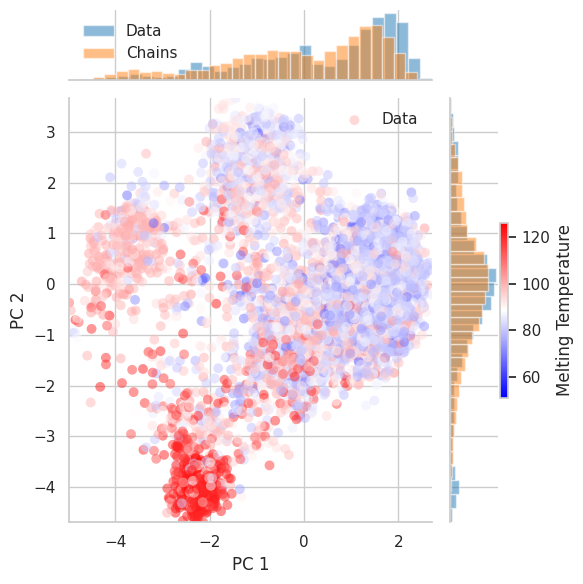

<Figure size 800x800 with 0 Axes>

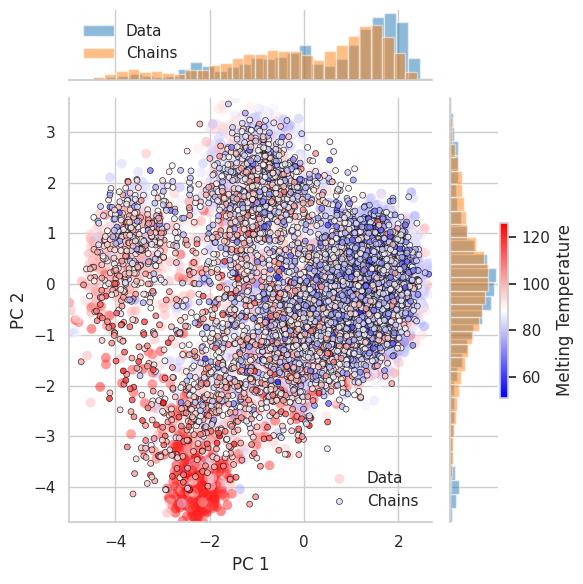

In [44]:
import seaborn as sns
import pandas as pd
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

fig = plt.figure(figsize=(8, 8), dpi=100)

# Put into a single DataFrame if desired (not strictly necessary)
df1 = pd.DataFrame({'x': data_proj[:, 0], 'y': data_proj[:, 1], 'label': labels_data, 'group': 'Data'})
df2 = pd.DataFrame({'x': chains_proj[:, 0], 'y': chains_proj[:, 1], 'label': labels_chains, 'group': 'Chains'})
df = pd.concat([df1, df2], ignore_index=True)

# Build a JointGrid for shared axes and custom marginals
sns.set_theme(style="whitegrid")
g = sns.JointGrid(x="x", y="y", data=df, height=6)

# Create a single colormap normalization across both datasets
vmin = df['label'].min()
vmax = df['label'].max()
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap("bwr")

# Plot scatter for each dataset separately on the same joint axes
ax = g.ax_joint
sc1 = ax.scatter(df1['x'], df1['y'], c=cmap(norm(df1['label'])), s=50, edgecolor='none', alpha=0.5, label='Data')
sc2 = ax.scatter(df2['x'], df2['y'], c=cmap(norm(df2['label'])), s=18, edgecolor='black', alpha=0.8, label='Chains', linewidth=0.5)

ax.legend(frameon=False, loc="best")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

# Add a single colorbar representing the continuous variable
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cb = plt.colorbar(sm, ax=g.ax_marg_y, pad=0.02)
cb.set_label("Melting Temperature")

# Marginal histograms for each dataset, overlaid
# Top (x) histogram
g.ax_marg_x.hist(df1['x'], bins=30, density=True, color="#1f77b4", alpha=0.5, label='Data')
g.ax_marg_x.hist(df2['x'], bins=30, density=True, color="#ff7f0e", alpha=0.5, label='Chains')
g.ax_marg_x.set_xlim(df['x'].min(), df['x'].max())
g.ax_marg_x.set_ylabel("Density")
g.ax_marg_x.legend(frameon=False, loc="best")

# Right (y) histogram
g.ax_marg_y.hist(df1['y'], bins=30, density=True, color="#1f77b4", alpha=0.5, orientation="horizontal")
g.ax_marg_y.hist(df2['y'], bins=30, density=True, color="#ff7f0e", alpha=0.5, orientation="horizontal")
g.ax_marg_y.set_ylim(df['y'].min(), df['y'].max())
g.ax_marg_y.set_xlabel("Density")

plt.tight_layout()
plt.show()


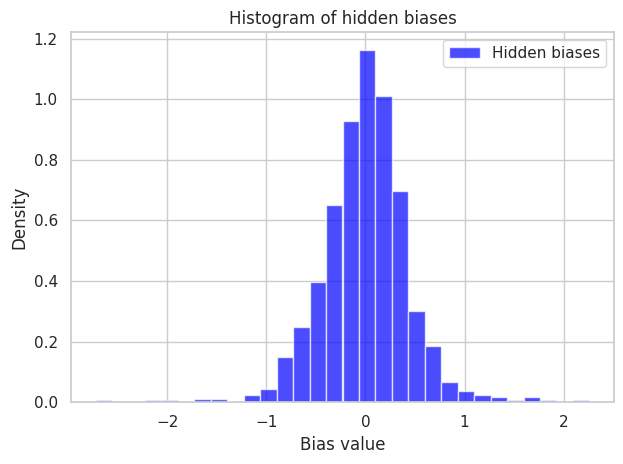

In [45]:
plt.hist(
    rbm.hidden_layer.bias.detach().cpu().numpy(),
    bins=30,
    density=True,
    alpha=0.7,
    color="blue",
    label="Hidden biases",
);
plt.legend()
plt.xlabel("Bias value")
plt.ylabel("Density")
plt.title("Histogram of hidden biases")
plt.tight_layout()

In [11]:
plt.hist(
    rbm.hidden_layer.scale.detach().cpu().numpy(),
    bins=30,
    alpha=0.7,
    color="blue",
    label="Hidden scales",
)
plt.legend()
plt.xlabel("Scale value")
plt.ylabel("Density")
plt.title("Histogram of hidden scales")
plt.tight_layout()

AttributeError: 'BernoulliLayer' object has no attribute 'scale'

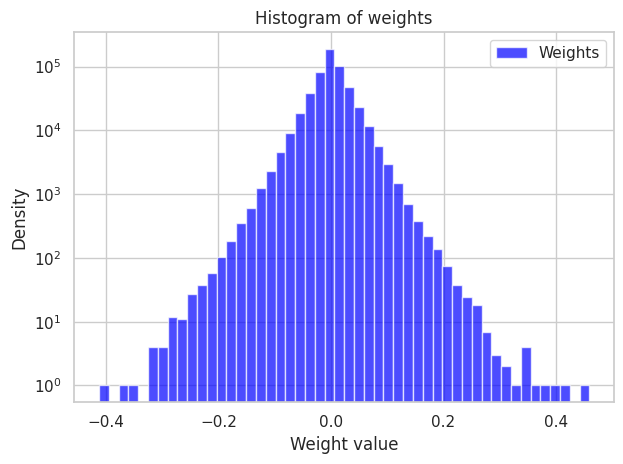

In [46]:
plt.hist(
    rbm.weight_matrix.detach().cpu().flatten().numpy(),
    bins=50,
    alpha=0.7,
    color="blue",
    label="Weights",
)
plt.legend()
plt.xlabel("Weight value")
plt.ylabel("Density")
plt.title("Histogram of weights")
plt.yscale("log")
plt.tight_layout()

### Sample unconditioned

In [47]:
samples = rbm.sample(gibbs_steps=10000, num_samples=10000)
samples_proj = pca.transform(samples["visible"].view(len(samples["visible"]), -1).cpu().numpy())
samples_labels = dataset.unstandardize_labels(samples["label"]).cpu().numpy()[:, 0]

df3 = pd.DataFrame({'x': samples_proj[:, 0], 'y': samples_proj[:, 1], 'label': samples_labels, 'group': 'Samples'})

W1007 18:25:53.115000 1747312 site-packages/torch/_inductor/utils.py:1436] [0/0] Not enough SMs to use max_autotune_gemm mode


<Figure size 800x800 with 0 Axes>

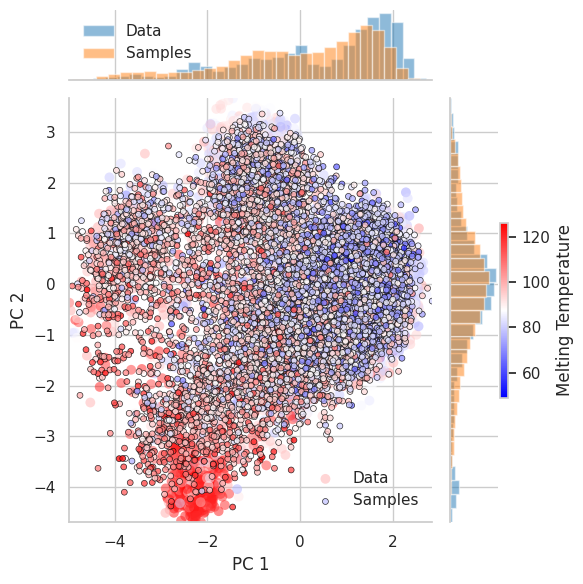

In [48]:
fig = plt.figure(figsize=(8, 8), dpi=100)
df = pd.concat([df1, df3], ignore_index=True)

# Build a JointGrid for shared axes and custom marginals
sns.set_theme(style="whitegrid")
g = sns.JointGrid(x="x", y="y", data=df, height=6)

# Create a single colormap normalization across both datasets
vmin = df['label'].min()
vmax = df['label'].max()
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap("bwr")

# Plot scatter for each dataset separately on the same joint axes
ax = g.ax_joint
sc1 = ax.scatter(df1['x'], df1['y'], c=cmap(norm(df1['label'])), s=50, edgecolor='none', alpha=0.5, label='Data')
sc2 = ax.scatter(df3['x'], df3['y'], c=cmap(norm(df3['label'])), s=18, edgecolor='black', alpha=0.8, label='Samples', linewidth=0.5)

ax.legend(frameon=False, loc="best")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

# Add a single colorbar representing the continuous variable
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cb = plt.colorbar(sm, ax=g.ax_marg_y, pad=0.02)
cb.set_label("Melting Temperature")

# Marginal histograms for each dataset, overlaid
# Top (x) histogram
g.ax_marg_x.hist(df1['x'], bins=30, density=True, color="#1f77b4", alpha=0.5, label='Data')
g.ax_marg_x.hist(df3['x'], bins=30, density=True, color="#ff7f0e", alpha=0.5, label='Samples')
g.ax_marg_x.set_xlim(df['x'].min(), df['x'].max())
g.ax_marg_x.set_ylabel("Density")
g.ax_marg_x.legend(frameon=False, loc="best")

# Right (y) histogram
g.ax_marg_y.hist(df1['y'], bins=30, density=True, color="#1f77b4", alpha=0.5, orientation="horizontal")
g.ax_marg_y.hist(df3['y'], bins=30, density=True, color="#ff7f0e", alpha=0.5, orientation="horizontal")
g.ax_marg_y.set_ylim(df['y'].min(), df['y'].max())
g.ax_marg_y.set_xlabel("Density")

plt.tight_layout()
plt.show()

In [49]:
pi = get_freq_single_point(samples["visible"])
pij = get_freq_two_points(samples["visible"])
rho, slope = get_correlation_two_points(fij, pij, fi, pi)
print(f"Correlation: {rho}, Slope: {slope}")

Correlation: 0.9288597106933594, Slope: 0.9108198881149292


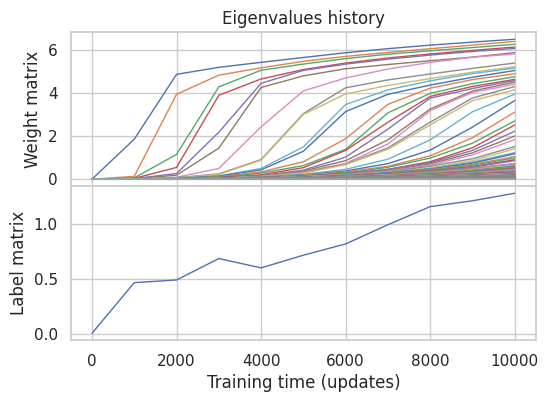

In [50]:
updates, eigenvalues = get_eigenvalues_history(checkpoint_dir, target_matrix="weight_matrix", device=device, dtype=dtype)
updates, eigenvalues_labels = get_eigenvalues_history(checkpoint_dir, target_matrix="label_matrix", device=device, dtype=dtype)

# Plot the eigenvalues history. first row is the weight matrix, second row is the label matrix.
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True, gridspec_kw={'hspace': 0})
ax[0].plot(updates, eigenvalues, lw=1)
ax[1].plot(updates, eigenvalues_labels, lw=1)
ax[1].set_xlabel("Training time (updates)")
ax[0].set_ylabel("Weight matrix")
ax[1].set_ylabel("Label matrix")
ax[0].set_title("Eigenvalues history");

### Conditioned sampling

In [51]:
cond_chains = rbm.sample_conditioned(
    gibbs_steps=10000,
    targets=dataset.labels_one_hot,
)

In [52]:
cond_chains_proj = pca.transform(cond_chains["visible"].view(len(cond_chains["visible"]), -1).cpu().numpy())
cond_chains_labels = labels_data
df4 = pd.DataFrame({'x': cond_chains_proj[:, 0], 'y': cond_chains_proj[:, 1], 'label': cond_chains_labels, 'group': 'Cond. Chains'})

<Figure size 800x800 with 0 Axes>

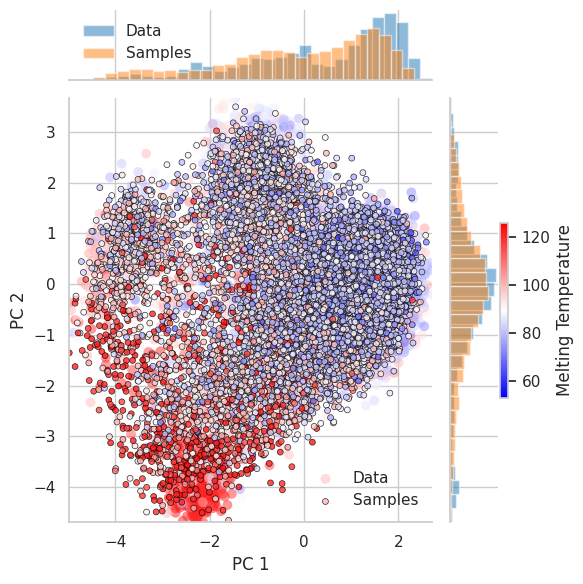

In [53]:
fig = plt.figure(figsize=(8, 8), dpi=100)
df = pd.concat([df1, df4], ignore_index=True)

# Build a JointGrid for shared axes and custom marginals
sns.set_theme(style="whitegrid")
g = sns.JointGrid(x="x", y="y", data=df, height=6)

# Create a single colormap normalization across both datasets
vmin = df['label'].min()
vmax = df['label'].max()
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap("bwr")

# Plot scatter for each dataset separately on the same joint axes
ax = g.ax_joint
sc1 = ax.scatter(df1['x'], df1['y'], c=cmap(norm(df1['label'])), s=50, edgecolor='none', alpha=0.5, label='Data')
sc2 = ax.scatter(df4['x'], df4['y'], c=cmap(norm(df4['label'])), s=18, edgecolor='black', alpha=0.8, label='Samples', linewidth=0.5)

ax.legend(frameon=False, loc="best")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

# Add a single colorbar representing the continuous variable
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cb = plt.colorbar(sm, ax=g.ax_marg_y, pad=0.02)
cb.set_label("Melting Temperature")

# Marginal histograms for each dataset, overlaid
# Top (x) histogram
g.ax_marg_x.hist(df1['x'], bins=30, density=True, color="#1f77b4", alpha=0.5, label='Data')
g.ax_marg_x.hist(df4['x'], bins=30, density=True, color="#ff7f0e", alpha=0.5, label='Samples')
g.ax_marg_x.set_xlim(df['x'].min(), df['x'].max())
g.ax_marg_x.set_ylabel("Density")
g.ax_marg_x.legend(frameon=False, loc="best")

# Right (y) histogram
g.ax_marg_y.hist(df1['y'], bins=30, density=True, color="#1f77b4", alpha=0.5, orientation="horizontal")
g.ax_marg_y.hist(df4['y'], bins=30, density=True, color="#ff7f0e", alpha=0.5, orientation="horizontal")
g.ax_marg_y.set_ylim(df['y'].min(), df['y'].max())
g.ax_marg_y.set_xlabel("Density")

plt.tight_layout()
plt.show()

In [54]:
pi = get_freq_single_point(cond_chains["visible"])
pij = get_freq_two_points(cond_chains["visible"])
rho, slope = get_correlation_two_points(fij, pij, fi, pi)
print(f"Correlation: {rho}, Slope: {slope}")

Correlation: 0.9229673147201538, Slope: 0.9506517648696899


In [55]:
from annadca.utils.functions import batched_mm_right

def predict_continuous_labels(rbm, visible):
    """Approximate predictions of the labels when the label is a Gaussian variable"""
    h = rbm.mean_hidden_activation(visible, torch.tensor([0.], device=visible.device, dtype=visible.dtype).unsqueeze(1))
    I_l = batched_mm_right(rbm.label_matrix, h) # (batch_size, num_classes)
    mean = (I_l + rbm.label_layer.bias) / rbm.label_layer.scale
    return mean.squeeze()

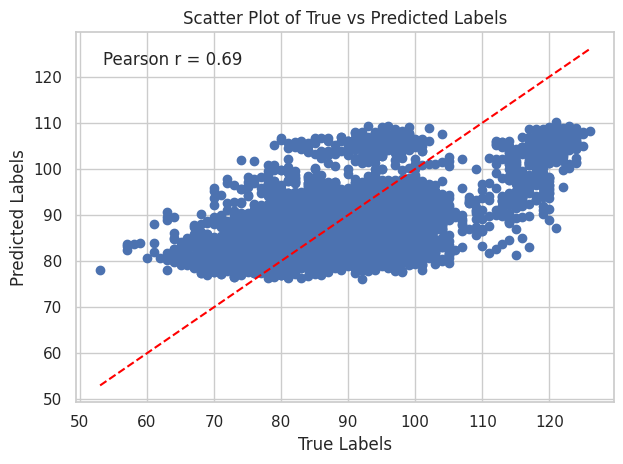

In [56]:
predictions = predict_continuous_labels(rbm, visible=dataset.data_one_hot)
predictions = dataset.unstandardize_labels(predictions).cpu().numpy()
targets = dataset.unstandardize_labels(dataset.labels_one_hot).squeeze().cpu().numpy()

# scatter plot and pearson correlation

plt.scatter(targets, predictions)
x = np.linspace(targets.min(), targets.max(), 100)
plt.plot(x, x, color='red', linestyle='--')
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.title("Scatter Plot of True vs Predicted Labels")
corr = np.corrcoef(targets, predictions)[0, 1]
plt.annotate(f'Pearson r = {corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, verticalalignment='top')
plt.tight_layout()

### Check energies

In [15]:
energy_data = rbm.compute_energy_visibles(data)
energy_samples = rbm.compute_energy_visibles(samples["visible"])

plt.figure(figsize=(6,4))
plt.hist(energy_data.cpu().numpy(), bins=50, density=True, alpha=0.5, label="Data")
plt.hist(energy_samples.cpu().numpy(), bins=50, density=True, alpha=0.5, label="Samples")
plt.xlabel("Energy")
plt.ylabel("Density")
plt.legend()
plt.title("Energy distribution: Data vs Samples")
plt.tight_layout()

NameError: name 'samples' is not defined

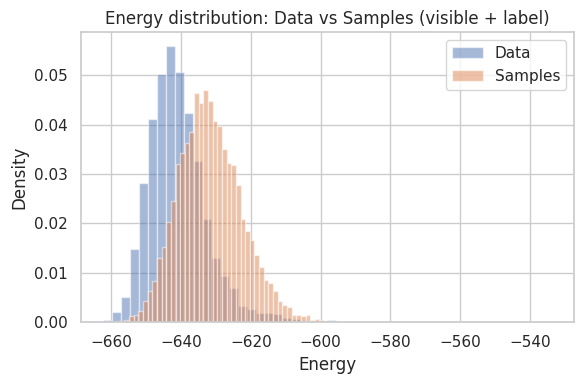

In [41]:
energy_visible_label_data = rbm.compute_energy_visibles_labels(data, dataset.labels_one_hot)
energy_visible_label_samples = rbm.compute_energy_visibles_labels(samples["visible"], samples["label"])

plt.figure(figsize=(6,4))
plt.hist(energy_visible_label_data.cpu().numpy(), bins=50, density=True, alpha=0.5, label="Data")
plt.hist(energy_visible_label_samples.cpu().numpy(), bins=50, density=True, alpha=0.5, label="Samples")
plt.xlabel("Energy")
plt.ylabel("Density")
plt.legend()
plt.title("Energy distribution: Data vs Samples (visible + label)")
plt.tight_layout()

In [ ]:
hidden_data = rbm.sample_hiddens(data, label=dataset.labels_one_hot)
energy_hidden_data = rbm.compute_energy_hiddens(hidden_data)
energy_hidden_samples = rbm.compute_energy_hiddens(samples["hidden"])

plt.figure(figsize=(6,4))
plt.hist(energy_hidden_data.cpu().numpy(), bins=50, density=True, alpha=0.5, label="Data")
plt.hist(energy_hidden_samples.cpu().numpy(), bins=50, density=True, alpha=0.5, label="Samples")
plt.xlabel("Energy")
plt.ylabel("Density")
plt.legend()
plt.title("Energy distribution: Hidden Data vs Hidden Samples")
plt.tight_layout()

KeyboardInterrupt: 

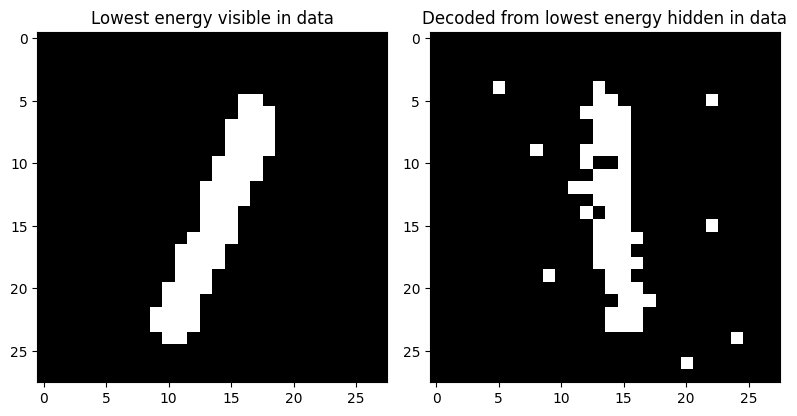

In [221]:
lowest_energy_hidden = hidden_data[energy_hidden_data.argmin()]
lowest_energy_hidden_decoded = rbm.sample_visibles(lowest_energy_hidden)
lowest_energy_visible = data[energy_data.argmin()]

fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].imshow(lowest_energy_visible.view(28,28).cpu(), cmap="gray")
ax[0].set_title("Lowest energy visible in data")
ax[1].imshow(lowest_energy_hidden_decoded.view(28,28).cpu(), cmap="gray")
ax[1].set_title("Decoded from lowest energy hidden in data")
fig.tight_layout()

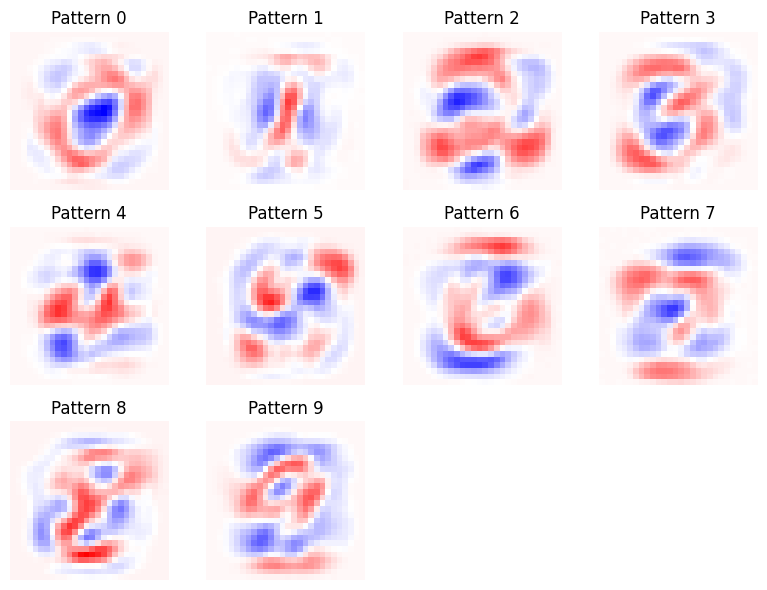

In [222]:
patterns = rbm.get_patterns()

plt.figure(figsize=(8,6))
num_patterns = patterns.shape[0]
for i in range(num_patterns):
    plt.subplot(int(np.ceil(num_patterns/4)), 4, i+1)
    plt.imshow(patterns[i].cpu().numpy().reshape(28,28), cmap='bwr', vmin=patterns.min(), vmax=patterns.max())
    plt.axis('off')
    plt.title(f'Pattern {i}')
plt.tight_layout()